In [20]:
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import datetime
from binance.client import Client

# Initialize the Binance client
client = Client()

In [21]:
startDate = '2022-01-01 00:00:00'
testDate  = '2024-06-01 00:00:00'
data = client.get_historical_klines('BTCUSDT','1h',startDate)

In [22]:
# # Endpoint for Coin-M Futures Kline data
# url = "https://dapi.binance.com/dapi/v1/klines"

# # Parameters for the request
# params = {
#     "symbol": 'BTCUSD_PERP',  # Futures trading pair
#     "interval": '1h',         # Kline interval (1m, 5m, 1h, etc.)
#     "startTime": '2022-01-01 00:00:00',
#     "endTime": '2024-01-01 00:00:00'
# }

# # Sending the GET request
# response = requests.get(url, params=params)

# # Check if the request was successful
# if response.status_code == 200:
#     data = response.json()
#     for candle in data:
#         print(f"Open: {candle[1]}, High: {candle[2]}, Low: {candle[3]}, Close: {candle[4]}")
# else:
#     print(f"Failed to fetch data: {response.status_code}, {response.text}")


In [23]:
df = pd.DataFrame(data)
colnames = ['openTime','openPrice','highPrice','lowPrice','closePrice','volume','closeTime','quoteAssetVolume','NumberOfTrades','TakerBaseVolume','TakerQuoteVolume','Ignore']
df.columns = colnames
df

,openTime,openPrice,highPrice,lowPrice,closePrice,volume,closeTime,quoteAssetVolume,NumberOfTrades,TakerBaseVolume,TakerQuoteVolume,Ignore
0,1640995200000,46216.93000000,46731.39000000,46208.37000000,46656.13000000,1503.33095000,1640998799999,69879986.39049930,38608,806.06536000,37462156.91764400,0
1,1640998800000,46656.14000000,46949.99000000,46574.06000000,46778.14000000,943.81539000,1641002399999,44127148.11760220,31872,491.18067000,22963272.85537420,0
2,1641002400000,46778.14000000,46928.94000000,46721.96000000,46811.77000000,485.16860000,1641005999999,22720670.41920010,24364,206.35113000,9662607.06589570,0
3,1641006000000,46811.77000000,46916.63000000,46760.12000000,46813.20000000,562.88971000,1641009599999,26363260.46336290,19882,248.28212000,11629376.39696030,0
4,1641009600000,46813.21000000,46887.33000000,46591.23000000,46711.05000000,861.88389000,1641013199999,40272043.73838760,23357,397.53563000,18575402.25911010,0
...,...,...,...,...,...,...,...,...,...,...,...,...
25658,1733367600000,101248.19000000,104088.00000000,101248.19000000,102964.00000000,12251.75148300,1733371199999,1259925511.70785437,1181421,6134.52338700,630664477.76319569,0
25659,1733371200000,102964.00000000,103544.71000000,102484.00000000,103339.96000000,4204.10271000,1733374799999,432886845.29644880,526380,1917.58308000,197446390.84574240,0
25660,1733374800000,103339.96000000,103455.13000000,101706.35000000,102450.01000000,3818.61708000,1733378399999,392319751.24256340,379758,2087.40962000,214403870.04817600,0
25661,1733378400000,102450.01000000,102662.46000000,101421.59000000,101904.02000000,3820.02291000,1733381999999,389486888.90914760,351342,2159.63050000,220170358.11973550,0


In [24]:

df['closeTime'] = pd.to_datetime(df['closeTime'], unit='ms')
df = df.astype({'closePrice':'float','openPrice':'float','highPrice':'float','lowPrice':'float','volume':'float'})
df['return'] = df['closePrice'].pct_change()
df['return_next'] = df['return'].shift(-1).fillna(0)
df['predict'] = 1
df.set_index("closeTime", inplace= True)

In [25]:
df

,openTime,openPrice,highPrice,lowPrice,closePrice,volume,quoteAssetVolume,NumberOfTrades,TakerBaseVolume,TakerQuoteVolume,Ignore,return,return_next,predict
closeTime,,,,,,,,,,,,,,
2022-01-01 00:59:59.999,1640995200000,46216.93,46731.39,46208.37,46656.13,1503.330950,69879986.39049930,38608,806.06536000,37462156.91764400,0,NaN,0.002615,1
2022-01-01 01:59:59.999,1640998800000,46656.14,46949.99,46574.06,46778.14,943.815390,44127148.11760220,31872,491.18067000,22963272.85537420,0,0.002615,0.000719,1
2022-01-01 02:59:59.999,1641002400000,46778.14,46928.94,46721.96,46811.77,485.168600,22720670.41920010,24364,206.35113000,9662607.06589570,0,0.000719,0.000031,1
2022-01-01 03:59:59.999,1641006000000,46811.77,46916.63,46760.12,46813.20,562.889710,26363260.46336290,19882,248.28212000,11629376.39696030,0,0.000031,-0.002182,1
2022-01-01 04:59:59.999,1641009600000,46813.21,46887.33,46591.23,46711.05,861.883890,40272043.73838760,23357,397.53563000,18575402.25911010,0,-0.002182,0.010308,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05 03:59:59.999,1733367600000,101248.19,104088.00,101248.19,102964.00,12251.751483,1259925511.70785437,1181421,6134.52338700,630664477.76319569,0,0.016947,0.003651,1
2024-12-05 04:59:59.999,1733371200000,102964.00,103544.71,102484.00,103339.96,4204.102710,432886845.29644880,526380,1917.58308000,197446390.84574240,0,0.003651,-0.008612,1
2024-12-05 05:59:59.999,1733374800000,103339.96,103455.13,101706.35,102450.01,3818.617080,392319751.24256340,379758,2087.40962000,214403870.04817600,0,-0.008612,-0.005329,1


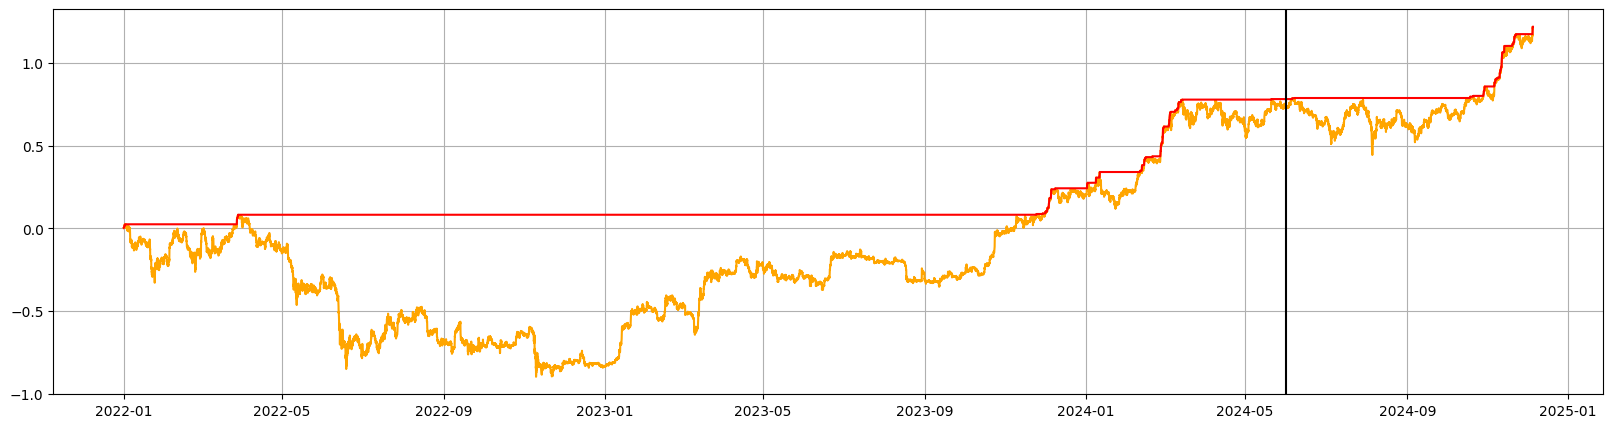

In [26]:
def func_plot(df):
  df['pnl'] = df['return_next'] * df['predict']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  plt.figure(figsize=(20,5))
  plt.plot(df['pnl_cumsum'],color='orange')
  plt.plot(df['pnl_cumsum_max'],color='red')
  plt.axvline(x = pd.to_datetime(testDate), color='black')
  plt.grid()
  plt.show()

func_plot(df)

In [27]:
df

,openTime,openPrice,highPrice,lowPrice,closePrice,volume,quoteAssetVolume,NumberOfTrades,TakerBaseVolume,TakerQuoteVolume,Ignore,return,return_next,predict,pnl,pnl_cumsum,pnl_cumsum_max,pnl_dd
closeTime,,,,,,,,,,,,,,,,,,
2022-01-01 00:59:59.999,1640995200000,46216.93,46731.39,46208.37,46656.13,1503.330950,69879986.39049930,38608,806.06536000,37462156.91764400,0,NaN,0.002615,1,0.002615,0.002615,0.002615,0.000000
2022-01-01 01:59:59.999,1640998800000,46656.14,46949.99,46574.06,46778.14,943.815390,44127148.11760220,31872,491.18067000,22963272.85537420,0,0.002615,0.000719,1,0.000719,0.003334,0.003334,0.000000
2022-01-01 02:59:59.999,1641002400000,46778.14,46928.94,46721.96,46811.77,485.168600,22720670.41920010,24364,206.35113000,9662607.06589570,0,0.000719,0.000031,1,0.000031,0.003365,0.003365,0.000000
2022-01-01 03:59:59.999,1641006000000,46811.77,46916.63,46760.12,46813.20,562.889710,26363260.46336290,19882,248.28212000,11629376.39696030,0,0.000031,-0.002182,1,-0.002182,0.001182,0.003365,0.002182
2022-01-01 04:59:59.999,1641009600000,46813.21,46887.33,46591.23,46711.05,861.883890,40272043.73838760,23357,397.53563000,18575402.25911010,0,-0.002182,0.010308,1,0.010308,0.011491,0.011491,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05 03:59:59.999,1733367600000,101248.19,104088.00,101248.19,102964.00,12251.751483,1259925511.70785437,1181421,6134.52338700,630664477.76319569,0,0.016947,0.003651,1,0.003651,1.216756,1.216756,0.000000
2024-12-05 04:59:59.999,1733371200000,102964.00,103544.71,102484.00,103339.96,4204.102710,432886845.29644880,526380,1917.58308000,197446390.84574240,0,0.003651,-0.008612,1,-0.008612,1.208144,1.216756,0.008612
2024-12-05 05:59:59.999,1733374800000,103339.96,103455.13,101706.35,102450.01,3818.617080,392319751.24256340,379758,2087.40962000,214403870.04817600,0,-0.008612,-0.005329,1,-0.005329,1.202815,1.216756,0.013941


In [28]:
def func_model_performance(df):
  train = df[(df.index<testDate)].reindex()
  test = df[(df.index>=testDate)].reindex()

  pnl_train = round(train['pnl'].sum(),6)
  pnl_test = round(test['pnl'].sum(),6)

  mdd_train = round(train['pnl_dd'].max(),6)
  mdd_test = round(test['pnl_dd'].max(),6)

  sharpe_train = round(pnl_train/mdd_train,6)
  sharpe_test = round(pnl_test/mdd_test,6)

  print('            train     test')
  print('PNL      : {0: <10}'.format(pnl_train),'{0: <10}'.format(pnl_test))
  print('MDD      : {0: <10}'.format(mdd_train),'{0: <10}'.format(mdd_test))
  print('Sharpe      : {0: <10}'.format(sharpe_train),'{0: <10}'.format(sharpe_test))
  return sharpe_train

In [29]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)

    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.

    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/

    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal

        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
            Histogram = MA

In [30]:
df.ta(kind='MACD',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=6)

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
closeTime,,,
2022-01-01 00:59:59.999,NaN,NaN,NaN
2022-01-01 01:59:59.999,NaN,NaN,NaN
2022-01-01 02:59:59.999,NaN,NaN,NaN
2022-01-01 03:59:59.999,NaN,NaN,NaN
2022-01-01 04:59:59.999,NaN,NaN,NaN
...,...,...,...
2024-12-05 03:59:59.999,1212.947306,567.710672,645.236634
2024-12-05 04:59:59.999,1485.078015,671.873105,813.204910
2024-12-05 05:59:59.999,1610.368707,637.731038,972.637669


In [31]:
df.dtypes

openTime              int64
openPrice           float64
highPrice           float64
lowPrice            float64
closePrice          float64
volume              float64
quoteAssetVolume     object
NumberOfTrades        int64
TakerBaseVolume      object
TakerQuoteVolume     object
Ignore               object
return              float64
return_next         float64
predict               int64
pnl                 float64
pnl_cumsum          float64
pnl_cumsum_max      float64
pnl_dd              float64
MACD_12_26_9        float64
MACDh_12_26_9       float64
MACDs_12_26_9       float64
dtype: object

In [32]:
columns_to_convert = ['quoteAssetVolume', 'TakerBaseVolume', 'TakerQuoteVolume', 'Ignore']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [33]:
def func_features(df):
    for length in [6, 12, 16, 20, 25, 30, 50]:
        # Simple Moving Average (SMA) and related signal
        df.ta(kind='SMA', append=True, centered=False, close='closePrice', length=length)
        df[f'f_SMA_{length}'] = np.where(df['closePrice'] > df[f'SMA_{length}'], -1, 1)

        # Trend-based feature using rolling returns
        df[f'f_trend_{length}'] = np.where(df['return'].rolling(window=length).sum() > 0, -1, 1)

        # Average True Range (ATR)
        df.ta(kind='ATR', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=length)
        df[f'f_ATR_{length}'] = np.where(df[f'ATRr_{length}'] > df[f'ATRr_{length}'].rolling(window=6).mean(), 1, -1)

        # Relative Strength Index (RSI)
        df.ta(kind='RSI', append=True, centered=False, close='closePrice', length=length)
        df[f'f_RSI_{length}'] = np.where(df[f'RSI_{length}'] < 20, 1, np.where(df[f'RSI_{length}'] > 80, -1, 0))

        # Price Volume Trend (PVT)
        df.ta(kind='PVT', append=True, centered=False, volume='volume', close='closePrice')
        df[f'f_PVT_{length}'] = np.where(df['PVT'] > df['PVT'].rolling(window=length).mean(), 1, -1)

        # Bollinger Bands
        df.ta(kind='BBANDS', append=True, centered=False, close='closePrice', length=length)
        df[f'f_bb_{length}_low'] = np.where(df['closePrice'] < df[f'BBL_{length}_2.0'], 1, 0)
        df[f'f_bb_{length}_high'] = np.where(df['closePrice'] > df[f'BBU_{length}_2.0'], -1, 0)

    # Moving Average Convergence Divergence (MACD)
    df.ta(kind='MACD', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=6)
    df['f_macd'] = np.where(df['MACDh_12_26_9'] > 0, 1, -1)

    # On-Balance Volume (OBV)
    df.ta(kind='OBV', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=6)
    df['f_OBV'] = np.where(df['OBV'] < df['OBV'].rolling(window=12).mean(), -1, 1)

    # Momentum Indicator (MOM)
    df.ta(kind='MOM', append=True, centered=False, close='closePrice', length=10)
    df['f_momentum'] = np.where(df['MOM_10'] > 0, 1, -1)

    # Additional features
    df['f_high'] = df['highPrice'].pct_change().fillna(0)
    df['f_low'] = df['lowPrice'].pct_change().fillna(0)
    df['f_high_low'] = (df['highPrice'] - df['lowPrice']) / (df['highPrice'] + df['lowPrice']).fillna(0)
    df['f_open_close'] = (df['openPrice'] - df['closePrice']) / (df['openPrice'] + df['closePrice']).fillna(0)
    df['f_ntv'] = df['NumberOfTrades'].pct_change().where(df['NumberOfTrades'].pct_change() != np.inf, np.nan).ffill().fillna(0)
    df['f_taker_volume_ratio'] = (df['TakerBaseVolume'] / df['volume']).fillna(0)
    df['f_rolling_std'] = df['closePrice'].rolling(window=20).std().fillna(0)

    # Lagged returns
    for lag in [1, 2, 3, 5, 10]:
        df[f'lag_return_{lag}'] = df['return'].shift(lag)

    # Feature engineering for targets
    df['return_next_class'] = np.where(df['return_next'] > 0, 1, 0)

    return df

In [34]:
df = func_features(df)

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

def func_train_model(modelType,df,testDate):
  features = [col for col in df if col.startswith('f_')]
  #print(features)
  train = df[(df.index<testDate)].reindex()
  test = df[(df.index>=testDate)].reindex()
  X_train = train[features]
  if modelType == 'lr':
    y_train = train['return_next']
    model = LinearRegression()
    model.fit(X_train,y_train)
  if modelType == 'dt':
    y_train = train['return_next_class']
    model = DecisionTreeClassifier(random_state=0,max_depth=5)
    model.fit(X_train,y_train)

  df['predict'] = model.predict(df[features])
  df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))
  df['pnl'] = df['predict'] * df['return_next']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  return df

In [36]:
df = func_train_model('lr', df, testDate)

In [37]:
sharpe = func_model_performance(df)

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  


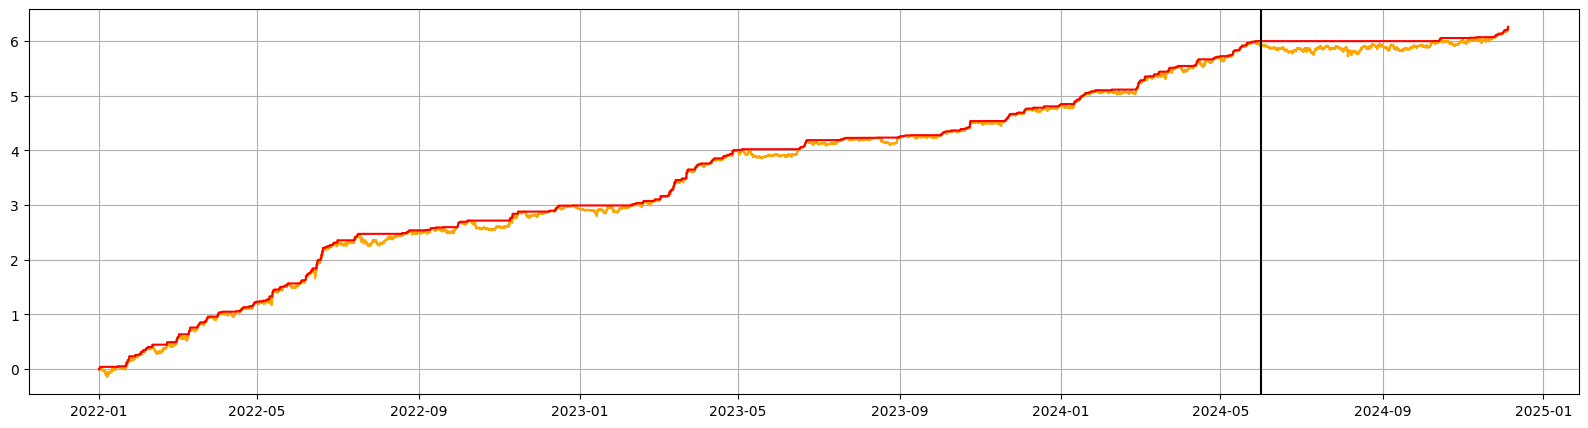

In [38]:
func_plot(df)

In [39]:
import optuna
from functools import partial

def objective(trial, testDate=testDate, df=df):

  #length_rsi = int(trial.suggest_categorical("length_rsi",["6","12","18","24","30","36"]))
  #length_pvt = int(trial.suggest_categorical("length_pvt",["6","12","18","24","30","36"]))
  model_type = trial.suggest_categorical("model_type",["lr","dt"])

  df = func_features(df)
  df = func_train_model(model_type,df,testDate)
  sharpe = func_model_performance(df)

  return sharpe

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 20, timeout = 1000, show_progress_bar = True)

[I 2024-12-05 10:38:01,661] A new study created in memory with name: no-name-472a7c1f-3edc-4839-bd2e-86b081140cfa
Best trial: 0. Best value: 26.6083:   5%|▌         | 1/20 [00:01<00:25,  1.36s/it, 1.36/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:03,018] Trial 0 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  10%|█         | 2/20 [00:01<00:15,  1.14it/s, 1.90/1000 seconds]

            train     test
PNL      : 1.665595   0.430956  
MDD      : 0.485765   0.313659  
Sharpe      : 3.428808   1.373963  
[I 2024-12-05 10:38:03,556] Trial 1 finished with value: 3.428808 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  15%|█▌        | 3/20 [00:02<00:13,  1.23it/s, 2.63/1000 seconds]

            train     test
PNL      : 1.665595   0.430956  
MDD      : 0.485765   0.313659  
Sharpe      : 3.428808   1.373963  
[I 2024-12-05 10:38:04,292] Trial 2 finished with value: 3.428808 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  20%|██        | 4/20 [00:04<00:18,  1.16s/it, 4.32/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:05,981] Trial 3 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  25%|██▌       | 5/20 [00:05<00:14,  1.01it/s, 5.00/1000 seconds]

            train     test
PNL      : 1.665595   0.430956  
MDD      : 0.485765   0.313659  
Sharpe      : 3.428808   1.373963  
[I 2024-12-05 10:38:06,666] Trial 4 finished with value: 3.428808 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  30%|███       | 6/20 [00:05<00:11,  1.17it/s, 5.60/1000 seconds]

            train     test
PNL      : 1.665595   0.430956  
MDD      : 0.485765   0.313659  
Sharpe      : 3.428808   1.373963  
[I 2024-12-05 10:38:07,265] Trial 5 finished with value: 3.428808 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  35%|███▌      | 7/20 [00:07<00:14,  1.08s/it, 7.15/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:08,814] Trial 6 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  40%|████      | 8/20 [00:07<00:10,  1.11it/s, 7.67/1000 seconds]

            train     test
PNL      : 1.665595   0.430956  
MDD      : 0.485765   0.313659  
Sharpe      : 3.428808   1.373963  
[I 2024-12-05 10:38:09,328] Trial 7 finished with value: 3.428808 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  45%|████▌     | 9/20 [00:08<00:08,  1.29it/s, 8.17/1000 seconds]

            train     test
PNL      : 1.665595   0.430956  
MDD      : 0.485765   0.313659  
Sharpe      : 3.428808   1.373963  
[I 2024-12-05 10:38:09,827] Trial 8 finished with value: 3.428808 and parameters: {'model_type': 'dt'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  50%|█████     | 10/20 [00:09<00:10,  1.01s/it, 9.69/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:11,355] Trial 9 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  55%|█████▌    | 11/20 [00:11<00:10,  1.13s/it, 11.09/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:12,755] Trial 10 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  60%|██████    | 12/20 [00:12<00:09,  1.14s/it, 12.27/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:13,927] Trial 11 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  65%|██████▌   | 13/20 [00:13<00:08,  1.19s/it, 13.55/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:15,203] Trial 12 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  70%|███████   | 14/20 [00:15<00:08,  1.36s/it, 15.30/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:16,964] Trial 13 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  75%|███████▌  | 15/20 [00:17<00:07,  1.46s/it, 17.02/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:18,679] Trial 14 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  80%|████████  | 16/20 [00:18<00:06,  1.56s/it, 18.80/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:20,458] Trial 15 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  85%|████████▌ | 17/20 [00:20<00:04,  1.54s/it, 20.31/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:21,970] Trial 16 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  90%|█████████ | 18/20 [00:21<00:03,  1.51s/it, 21.75/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:23,408] Trial 17 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083:  95%|█████████▌| 19/20 [00:23<00:01,  1.57s/it, 23.45/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:25,105] Trial 18 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.


Best trial: 0. Best value: 26.6083: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it, 24.83/1000 seconds]

            train     test
PNL      : 5.910132   0.339953  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.225074  
[I 2024-12-05 10:38:26,490] Trial 19 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 0 with value: 26.608313.
